### Data Collection  

In this step, we fetch historical stock price data for **Tech Mahindra (NSE: TECHM)** using the `yfinance` library.  

- **Symbol used**: `"TECHM.BO"` (Tech Mahindra listed on the Bombay Stock Exchange).  
- **Date range**: From *2020-08-23* to *2025-08-23*.  
- The data includes daily **Date,Open, High, Low, Close, and Volume** values.
- After downloading, the dataset is saved as a CSV file (`TECHM.csv`) for future reference.  

This ensures we have a structured dataset ready for time series modeling with ARIMA and Prophet (additional)

In [1]:
import yfinance as yf

In [3]:
symbol = "TECHM.BO"

data = yf.download(symbol, start="2020-08-23", end="2025-08-23")

data.to_csv("TECHM.csv")
print("CSV saved successfully!")

/var/folders/x2/sv4n6ff97g360s95c_r6941m0000gn/T/ipykernel_54047/1215217905.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start="2020-08-23", end="2025-08-23")
[*********************100%***********************]  1 of 1 completed

CSV saved successfully!


### Importing Required Libraries  

To work with the stock price dataset and perform analysis, we import the following libraries:  

- **pandas** → For data manipulation and handling tabular structures.  
- **matplotlib.pyplot** → For creating basic plots and visualizations.  
- **seaborn** → For enhanced and aesthetically pleasing statistical graphics.  

These libraries will help us explore, analyze, and visualize the Tech Mahindra stock data effectively.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the Dataset  

We now load the saved CSV file (**TECHM.csv**) into a **pandas DataFrame**.  
This allows us to conveniently work with the stock price data in a structured, tabular format.  

- `pd.read_csv("TECHM.csv")` → Reads the CSV file and stores it as a DataFrame.  
- The DataFrame will contain columns like `Date`, `Open`, `High`, `Low`, `Close`, and `Volume`. 

In [2]:
data = pd.read_csv("TECHM.csv")

### Converting Date Column to DateTime Format  

The `Date` column is currently read as a string (object type) from the CSV file.  
To perform **time-series operations** (like resampling, filtering by year, or plotting trends), we need to convert it into a **datetime object**.  

- `pd.to_datetime(data['Date'])` → Converts the `Date` column into proper datetime format.  
- This enables pandas to understand it as **time-series data** instead of plain text.  

In [3]:
data['Date'] = pd.to_datetime(data['Date'])

### Setting the Date Column as Index  

After converting the `Date` column into datetime format, we set it as the **index**.  
This transforms the DataFrame into a **time-series indexed dataset**, which makes it easier to:  

- Slice data by specific dates or ranges (`data['2023']`, `data['2023-05']`, etc.)  
- Perform resampling (daily, weekly, monthly averages)  
- Create cleaner time-series plots with matplotlib/seaborn 

In [4]:
data.set_index('Date', inplace=True)

### Inspecting the First Few Rows  

This help us to verify if the `Date` column was successfully set as the index and to quickly review the dataset structure.

In [5]:
print(data.head())

                 Close        High         Low        Open  Volume
Date                                                              
2020-08-24  606.235535  616.553356  603.551210  616.469492  259310
2020-08-25  619.657043  620.705603  599.356911  608.584239  144087
2020-08-26  614.623962  621.586391  609.842518  619.992559   92847
2020-08-27  616.763000  625.780617  614.875592  614.875592   70380
2020-08-28  631.023438  635.888746  618.314869  618.314869  113579


### Dataset Information  

This help us to understand the structure, data types, and missing values in our dataset.

In [6]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1218 entries, 2020-08-24 to 2025-08-22
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1218 non-null   float64
 1   High    1218 non-null   float64
 2   Low     1218 non-null   float64
 3   Open    1218 non-null   float64
 4   Volume  1218 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 57.1 KB
None


### Visualizing Closing Price Trend  

We plot the **closing price** of Tech Mahindra over time to visually inspect trends, patterns, and potential seasonality.  

- `plt.plot(data['Close'])` → Plots the closing prices over the time index (Date).  
- `figsize=(12,6)` → Makes the plot wider for better readability.  
- Labels and legend are added for clarity.  

This visualization helps identify:  
- Long-term trends (upward/downward)  
- Volatility and fluctuations  
- Potential periods of spikes or dips

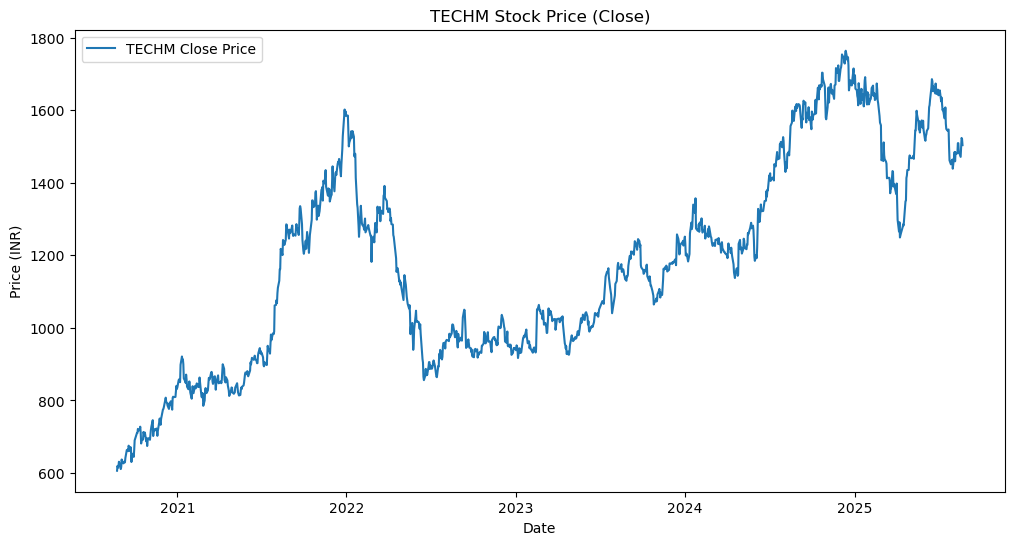

In [7]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='TECHM Close Price')
plt.title("TECHM Stock Price (Close)")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.show()

### Checking for Missing Values  

Before building time series models, it’s important to verify that the dataset has **no missing values**, as gaps can affect forecasting accuracy.

In [8]:
print(data.isnull().sum())

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


### Stationarity Check with Augmented Dickey-Fuller (ADF) Test  

Time series models like **ARIMA** require the data to be **stationary** (constant mean and variance over time).  

- We use the **ADF test** from `statsmodels` to check stationarity.  
- **Hypotheses of ADF test**:  
  - H0: The series is non-stationary  
  - H1: The series is stationary  
- Key outputs:  
  - `ADF Statistic` → Test statistic value  
  - `p-value` → Significance of the result (p < 0.05 indicates stationarity)  

This step helps determine if **differencing** is needed before fitting ARIMA.

In [9]:
!pip install statsmodels

In [10]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.8086747297320749
p-value: 0.37616351551223237


### Differencing to Achieve Stationarity  

The **ADF test** showed:  
- `ADF Statistic = -1.81`  
- `p-value = 0.376` > 0.05  

This indicates that the **closing price series is non-stationary**.  

To make it stationary, we apply **first-order differencing**:  

- `data['Close_diff'] = data['Close'].diff()` → Subtracts the previous day's closing price from the current day.  
- This removes trends and helps stabilize the mean of the series.  
- `dropna()` is used to remove the `NaN` created by differencing the first value.

In [11]:
data['Close_diff'] = data['Close'].diff().dropna()

### Autocorrelation (ACF) and Partial Autocorrelation (PACF) Plots  

To help identify the appropriate **ARIMA parameters (p, d, q)**, we visualize:  

- **ACF (Autocorrelation Function)** → Shows correlation between the series and its lagged values. Useful for determining the **MA (q) term**.  
- **PACF (Partial Autocorrelation Function)** → Shows correlation between the series and lagged values **after removing effects of intermediate lags**. Useful for determining the **AR (p) term**.  

- `lags=50` → We consider correlations up to 50 days.  
- These plots guide the selection of ARIMA parameters before fitting the model.

<Figure size 1200x600 with 0 Axes>

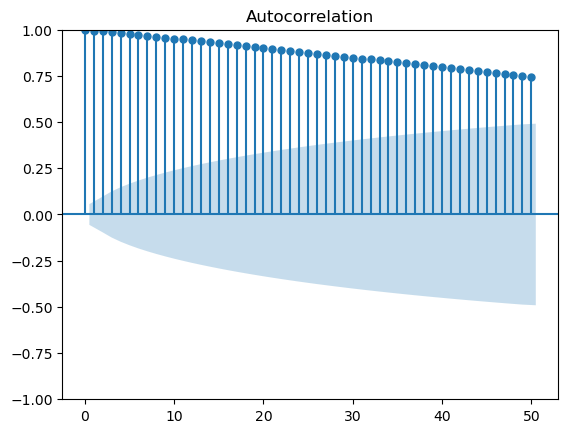

<Figure size 1200x600 with 0 Axes>

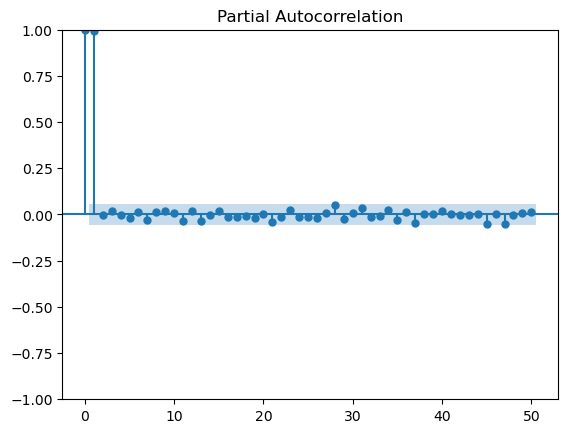

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,6))
plot_acf(data['Close'].dropna(), lags=50)
plt.show()

plt.figure(figsize=(12,6))
plot_pacf(data['Close'].dropna(), lags=50)
plt.show()

### Train-Test Split  

To evaluate the forecasting model, we split the dataset into **training and testing sets**:  

- **Training set**: First 80% of the data (`train_size = 0.8 * total_length`)  
- **Testing set**: Remaining 20% of the data  

This allows us to:  
- Fit the ARIMA model on historical data (training set)  
- Evaluate its predictive performance on unseen data (testing set)  

We also print the sizes of each set to confirm the split.

In [13]:
train_size = int(len(data) * 0.8)
train, test = data['Close'][:train_size], data['Close'][train_size:]

print("Train size:", len(train))
print("Test size:", len(test))

Train size: 974
Test size: 244


### Building and Fitting ARIMA Model  

We now build an **ARIMA model** to forecast stock prices:  

- **ARIMA(p, d, q)** parameters used:  
  - `p=5` → Number of autoregressive terms (AR)  
  - `d=1` → Number of differences to make the series stationary  
  - `q=0` → Number of moving average terms (MA)  

- `model.fit()` → Fits the ARIMA model to the **training set**.  
- `model_fit.summary()` → Provides a detailed summary including:  
  - Coefficients of AR/MA terms  
  - Model diagnostics  
  - AIC/BIC values for model evaluation  

This step trains the ARIMA model to capture the temporal patterns in the stock's closing prices.

In [14]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  974
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4283.714
Date:                Sat, 23 Aug 2025   AIC                           8579.429
Time:                        22:26:06   BIC                           8608.711
Sample:                             0   HQIC                          8590.573
                                - 974                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0584      0.027      2.192      0.028       0.006       0.111
ar.L2         -0.0542      0.031     -1.733      0.083      -0.116       0.007
ar.L3      -7.842e-05      0.029     -0.003      0.9

/opt/anaconda3/envs/dsenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dsenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### ARIMA Forecasting and Visualization  

After fitting the ARIMA model, we forecast the stock's closing prices for the **testing period**:  

- `steps=len(test)` → Forecasts the same number of points as the test set.  
- We align the forecasted values with the test set index for proper plotting.  

Visualization:  
- **Train set** → Shows historical data used for fitting  
- **Test set** → Actual values for comparison  
- **Forecast** → ARIMA model predictions  

This plot allows us to visually assess how well ARIMA captures the trend and movements of the stock price.

/opt/anaconda3/envs/dsenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/dsenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


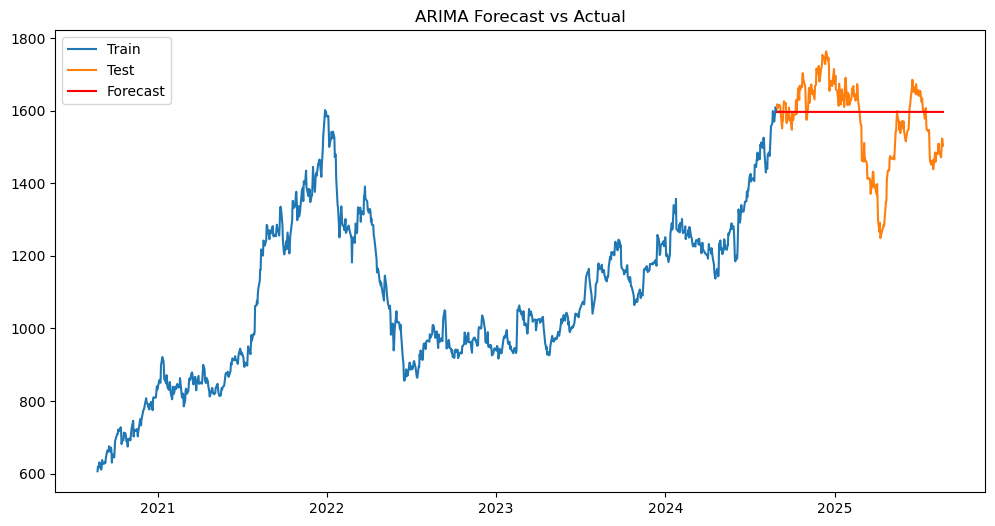

In [15]:
# Forecast on test set
forecast = model_fit.forecast(steps=len(test))
forecast.index = test.index

# Plot
plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast', color='red')
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.show()

### Evaluating ARIMA Forecast  

To measure the accuracy of our ARIMA model predictions, we compute the following metrics:  

- **Mean Absolute Error (MAE)** → Average absolute difference between actual and predicted values.  
- **Root Mean Squared Error (RMSE)** → Square root of the average squared differences; penalizes larger errors more heavily. 

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 84.75331328798983
RMSE: 110.55789365361241


### Saving ARIMA Forecast  

After generating the forecast, we save the predicted values to a CSV file for future use or further analysis:  

- `forecast.to_csv("ARIMA_forecast.csv")` → Saves the forecasted closing prices as `ARIMA_forecast.csv`.  
- This ensures that the predictions are **persisted** and can be referenced or visualized later without re-running the model.  

In [19]:
forecast.to_csv("ARIMA_forecast.csv")

### Installing Prophet  

To complement ARIMA forecasting, we will use **Prophet**, a library developed by Facebook/Meta for **time series forecasting**.  

- Prophet is particularly useful for stock price data because it can automatically handle:  
  - **Trend changes**  
  - **Seasonality** (daily, weekly, yearly)  
  - **Holidays or special events**

In [22]:
!pip install Prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 4.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [Prophet]m5/6 [Prophet]]


### Time Series Forecasting with Prophet  

We now build a **Prophet model** as an alternative to ARIMA for stock price prediction:  

1. **Data Preparation**  
   - Prophet expects the dataset with two columns:  
     - `ds` → Date column  
     - `y` → Target variable (closing price)  

2. **Model Training**  
   - `Prophet(daily_seasonality=True)` → Initializes the model with daily seasonality.  
   - The model is trained on the **training portion** of the data.  

3. **Forecasting**  
   - `make_future_dataframe(periods=len(test))` → Creates future dates equal to the test set length.  
   - `predict(future)` → Generates forecasted values including trend, seasonal components, and uncertainty intervals.  

4. **Visualization**  
   - `prophet_model.plot(forecast_prophet)` → Plots the forecast along with historical data.  
   - Helps visually compare predicted values with actual data and assess model performance.

19:31:02 - cmdstanpy - INFO - Chain [1] start processing
19:31:03 - cmdstanpy - INFO - Chain [1] done processing


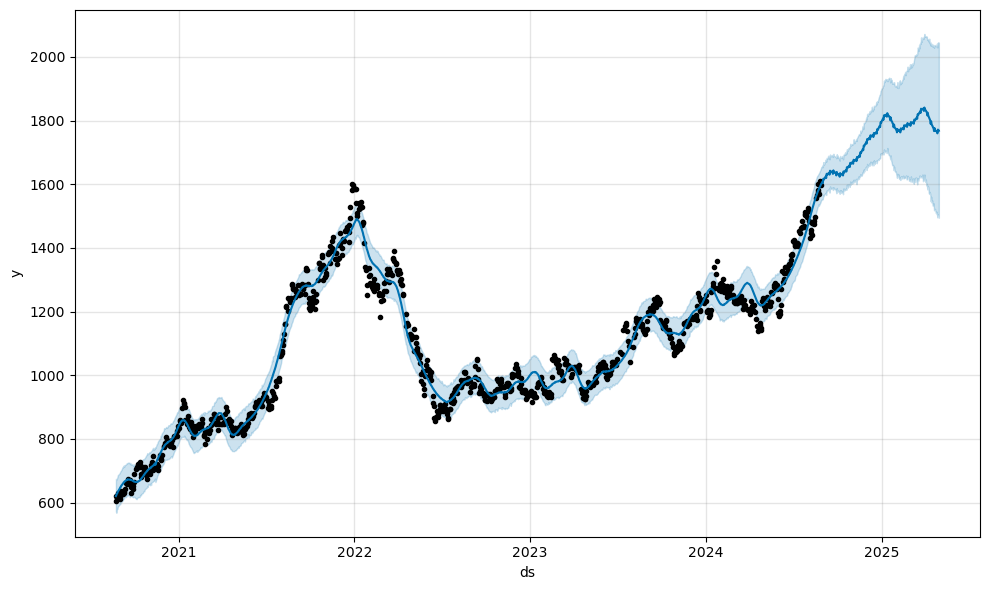

In [23]:
from prophet import Prophet

# Preparation
prophet_data = data['Close'].reset_index()
prophet_data.columns = ['ds','y']  # Prophet requires ds and y

# Train
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_data[:train_size])

# Forecasting
future = prophet_model.make_future_dataframe(periods=len(test))
forecast_prophet = prophet_model.predict(future)

# Visualize
prophet_model.plot(forecast_prophet)
plt.show()

### Saving Prophet Forecast  

After generating the forecast with Prophet, we save the predicted values to a CSV file:  

- `forecast_prophet[['ds','yhat']].to_csv("Prophet_forecast.csv")` → Saves the forecasted values with:  
  - `ds` → Date  
  - `yhat` → Predicted closing price  

This ensures the Prophet predictions are **persisted for future analysis or comparison** with ARIMA forecasts.

In [24]:
forecast_prophet[['ds','yhat']].to_csv("Prophet_forecast.csv")

## Summary and Comparison of Forecasting Models  

We implemented **two time series forecasting models** to predict Tech Mahindra stock prices:

### 1. ARIMA
- Captures trends and autocorrelations in the data.  
- Requires the series to be stationary; differencing was applied.  
- Forecast evaluated using **MAE** and **RMSE**.  
- Best for linear trends and short-term forecasting.

### 2. Prophet
- Handles trend changes, seasonality, and holidays automatically.  
- Does not require stationarity.  
- Produces forecasts with uncertainty intervals.  
- Suitable for complex patterns and longer-term forecasting.

### Observations
- Both models provide reasonable predictions, but the choice depends on:  
  - Nature of the time series (linear vs seasonal/non-linear)  
  - Forecast horizon (short-term vs long-term)  
  - Need for automatic handling of seasonality or events